In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3

In [2]:
def thin(A_,alpha_,beta_,a_A_,b_A_,a_alpha_,b_alpha_,a_beta_,b_beta_,thin_factor,burn):
    size=np.shape(A_)
    arr = np.arange(burn,size[0],thin_factor)
    a_A = np.ndarray.flatten(a_A_[arr])
    b_A = np.ndarray.flatten(b_A_[arr])
    a_alpha = np.ndarray.flatten(a_alpha_[arr])
    b_alpha = np.ndarray.flatten(b_alpha_[arr])
    a_beta = np.ndarray.flatten(a_beta_[arr])
    b_beta = np.ndarray.flatten(b_beta_[arr])
    A = A_[arr,:]
    alpha = alpha_[arr,:]
    beta = beta_[arr,:]
    return a_A,b_A,a_alpha,b_alpha,a_beta,b_beta,A,alpha,beta
    
def gen_val_distributed(A,a_A_,b_A_,a_alpha_,b_alpha_,a_beta_,b_beta_,M):  
    size=np.shape(A)
    N=size[1]
    L=size[0]    
    #A
    a1=a_A[np.random.randint(L,size=M)]
    b1=b_A[np.random.randint(L,size=M)]
    hier_A=np.random.gamma(a1,np.divide(1,b1))
    #alpha
    a2=a_alpha[np.random.randint(L,size=M)]
    b2=b_alpha[np.random.randint(L,size=M)]
    hier_alpha=np.random.gamma(a2,np.divide(1,b2))
    #beta
    a3=a_beta[np.random.randint(L,size=M)]
    b3=b_beta[np.random.randint(L,size=M)]
    hier_beta=np.random.gamma(a3,np.divide(1,b3))
    #delay
    hier_ind_delay = np.zeros([M,N])
    for i in range(N):
        a4=alpha[np.random.randint(L,size=M),i]
        b4=beta[np.random.randint(L,size=M),i]
        hier_ind_delay[:,i]=np.random.gamma(a4,np.divide(1,b4))
    hier_delay=hier_ind_delay.flatten()
    return hier_A, hier_alpha, hier_beta, hier_delay

def gen_mean_delay(M):
    size=np.shape(alpha)
    N=size[1]
    L=size[0]    
    hier_ind_delay = np.zeros([M,N])
    hier_mean_delay = np.zeros(N)
    for i in range(N):
        a4=alpha[np.random.randint(L,size=M),i]
        b4=beta[np.random.randint(L,size=M),i]
        hier_ind_delay[:,i]=np.random.gamma(a4,np.divide(1,b4))
        hier_mean_delay[i]=np.mean(hier_ind_delay[:,i])
    return hier_mean_delay

def plot_hyperparameters():
    f,axes = plt.subplots(4,3,figsize=(10,5))
    sns.kdeplot(a_A,shade=True,ax=axes[0,0])
    sns.kdeplot(a_alpha,shade=True,ax=axes[0,1])
    sns.kdeplot(a_beta,shade=True,ax=axes[0,2])
    sns.kdeplot(b_A,shade=True,ax=axes[1,0])
    sns.kdeplot(b_alpha,shade=True,ax=axes[1,1])
    sns.kdeplot(b_beta,shade=True,ax=axes[1,2])
    
    axes[2,0].plot(a_A,color='k',linewidth=0.5)
    axes[2,1].plot(a_alpha,color='k',linewidth=0.5)
    axes[2,2].plot(a_beta,color='k',linewidth=0.5)
    axes[3,0].plot(b_A,color='k',linewidth=0.5)
    axes[3,1].plot(b_alpha,color='k',linewidth=0.5)
    axes[3,2].plot(b_beta,color='k',linewidth=0.5)

    xlabels0=[r'$a_A$',r'$a_\alpha$',r'$a_\beta$']
    xlabels1=[r'$b_A$',r'$b_\alpha$',r'$b_\beta$']
    for j in range(3):
        for i in range(4):
            axes[i,j].spines['right'].set_color('none')
            axes[i,j].spines['top'].set_color('none')
            axes[i,j].tick_params(axis = 'both', which = 'major', labelsize = 10)
        axes[0,j].set_xlabel(xlabels0[j],fontsize=10) 
        axes[1,j].set_xlabel(xlabels1[j],fontsize=10) 
        axes[2,j].set_ylabel(xlabels0[j],fontsize=10) 
        axes[3,j].set_ylabel(xlabels1[j],fontsize=10) 
        axes[2,j].set_xlabel('Iteration')
        axes[3,j].set_xlabel('Iteration')
        axes[0,j].set_xticks(axes[0,j].get_xticks()[::1])
        axes[0,j].set_yticks(axes[0,j].get_yticks()[::1])
    axes[0,0].set_ylabel('PDF',fontsize=10)   
    axes[1,0].set_ylabel('PDF',fontsize=10)   
    
    plt.tight_layout(w_pad=2,h_pad=1)
    plt.suptitle('Hyperparameter Posterior Distributions',y=1.1)
    plt.show()
    data = [[r'$a_A$', np.mean(a_A), np.var(a_A)],
    [r'$b_A$', np.mean(b_A), np.var(b_A)],        
    [r'$a_\alpha$', np.mean(a_alpha), np.var(a_alpha)],
    [r'$b_\alpha$', np.mean(b_alpha), np.var(b_alpha)],
    [r'$a_\beta$', np.mean(a_beta), np.var(a_beta)],
    [r'$b_\beta$', np.mean(b_beta), np.var(b_beta)]]
    headers=['Hyperparameter', 'Mean', 'Variance']
    print(pd.DataFrame(data,np.arange(1,7),headers))
    
    
    hier_A, hier_alpha, hier_beta, hier_delay = gen_val_distributed(A,a_A_,b_A_,a_alpha_,b_alpha_,a_beta_,b_beta_,100000)
    f,axes = plt.subplots(1,4,figsize=(7,1.5))
    sns.kdeplot(hier_A,shade=True,ax=axes[0],color='C1')
    sns.kdeplot(hier_alpha,shade=True,ax=axes[1],color='C1')
    sns.kdeplot(hier_beta,shade=True,ax=axes[2],color='C1')
    sns.kdeplot(hier_delay,shade=True,ax=axes[3],color='C1')
    xlabels=[r'$A$',r'$\alpha$',r'$\beta$',r'$\tau$',]
    xlims=[pymc3.stats.hpd(hier_A)[1],pymc3.stats.hpd(hier_alpha)[1],pymc3.stats.hpd(hier_beta)[1],pymc3.stats.hpd(hier_delay)[1]]
    for i in range(4):
        axes[i].spines['right'].set_color('none')
        axes[i].spines['top'].set_color('none')
        axes[i].tick_params(axis = 'both', which = 'major', labelsize = 10)
        axes[i].set_xlabel(xlabels[i],fontsize=10) 
        axes[i].set_xlim([0,xlims[i]])
        axes[i].set_xticks(axes[i].get_xticks()[::2])
        axes[i].set_yticks(axes[i].get_yticks()[::2])
    axes[0].set_ylabel('PDF',fontsize=10)   
    plt.tight_layout()
    plt.suptitle('Population Posterior Distributions',y=1.1)
    plt.show()
    headers=['Parameter','Mean','Variance']
    data=[[r'$A$',np.mean(hier_A),np.var(hier_A)],
          [r'$\alpha$',np.mean(hier_alpha),np.var(hier_alpha)],
          [r'$\beta$',np.mean(hier_beta),np.var(hier_beta)],
          [r'$\tau$',np.mean(hier_delay),np.var(hier_delay)]]
    print(pd.DataFrame(data,[1,2,3,4],headers))  
    
def display_invidual_estimates():
    mean_delay = gen_mean_delay(100000)
    plt.figure(figsize=(2,2))
    plt.scatter(np.mean(A,0),mean_delay,s=20,color='C0')
    plt.gca().tick_params(axis = 'both', which = 'major', labelsize = 10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel(r'$\hat{A}_n$',fontsize=10)
    plt.ylabel(r'$\hat{\tau}_n$',fontsize=10)
    plt.title('Individual parameter estimates',y=1.05)
    plt.hlines(np.mean(mean_delay),0,max(np.mean(A,0)),color='k',alpha=0.5,linewidth=1)
    plt.vlines(np.mean(np.mean(A,0)),0,max(mean_delay),color='k',alpha=0.5,linewidth=1)
    plt.show()
    
    headers=[r'$A$ estimate',r'$\tau$ estimate']
    data=np.transpose([np.mean(A,0),mean_delay])
    print(pd.DataFrame(data,np.arange(1,np.shape(A)[1]+1),headers))
    


In [3]:
A_ = pd.read_csv("A.csv").values
alpha_ = pd.read_csv("alpha.csv").values
beta_ = pd.read_csv("beta.csv").values
a_A_ = pd.read_csv("a_A.csv").values
a_alpha_ = pd.read_csv("a_alpha.csv").values
a_beta_ = pd.read_csv("a_beta.csv").values
b_A_ = pd.read_csv("b_A.csv").values
b_alpha_ = pd.read_csv("b_alpha.csv").values
b_beta_ = pd.read_csv("b_beta.csv").values

thin_factor=5
burn = 1000
a_A,b_A,a_alpha,b_alpha,a_beta,b_beta,A,alpha,beta = thin(A_,alpha_,beta_,a_A_,b_A_,a_alpha_,b_alpha_,a_beta_,b_beta_,thin_factor,burn)

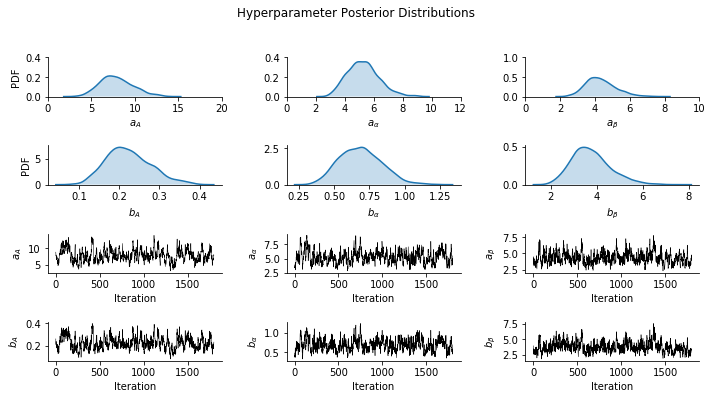

  Hyperparameter      Mean  Variance
1          $a_A$  7.908483  3.507178
2          $b_A$  0.223423  0.003015
3     $a_\alpha$  5.287041  1.160955
4     $b_\alpha$  0.687022  0.021656
5      $a_\beta$  4.324963  0.706752
6      $b_\beta$  3.746928  0.703020


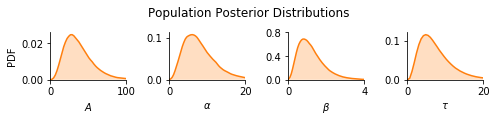

  Parameter       Mean    Variance
1       $A$  37.784918  374.328283
2  $\alpha$   8.078676   19.198218
3   $\beta$   1.212613    0.487096
4    $\tau$   7.559466   20.315902


In [4]:
plot_hyperparameters()

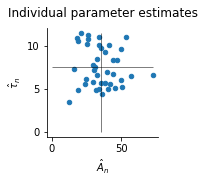

    $A$ estimate  $\tau$ estimate
1      57.170667         6.509357
2      33.786833        10.965653
3      19.111889         4.824336
4      50.813389         5.223840
5      35.946056         4.411202
6      73.420889         6.568795
7      12.581167         3.464914
8      32.100278         4.805536
9      47.115667         8.345590
10     29.772278         5.828340
11     35.539444         5.726768
12     31.371111         7.530132
13     49.925000         5.977911
14     25.336611        10.241207
15     35.685444         9.731076
16     40.197167         6.992558
17     44.202333         6.771990
18     18.372333        10.916947
19     32.762778         6.604607
20     38.598056         5.618212
21     42.248778         5.505770
22     20.880444        11.465898
23     45.409500         5.045395
24     16.065611         7.266012
25     29.871389         7.746258
26     33.834889        10.085799
27     38.091944         9.302799
28     40.649667         4.969857
29     34.2236

In [5]:
display_invidual_estimates()